### EDA: Trực quan hóa và phân phối điểm theo môn, tổ hợp và năm

# Theo Môn

In [2]:
# Xử lý data theo môn học
import sys
import os

# 1. Lấy đường dẫn hiện tại của file Notebook
current_dir = os.getcwd()

# 2. Lấy đường dẫn thư mục gốc (Project Root) bằng cách đi lùi ra 1 cấp
project_root = os.path.dirname(current_dir)

# 3. Thêm đường dẫn gốc vào hệ thống để Python tìm thấy 'Module'
if project_root not in sys.path:
    sys.path.append(project_root)

print(f"Đã thêm đường dẫn gốc: {project_root}")

from Module.Processor_Data import DataProcessor
from Module.Analysis import Analysis

Đã thêm đường dẫn gốc: c:\Users\ACER\PythonProject\PythonProject


In [3]:
# Load dữ liệu & chuẩn bị module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from Module.Processor_Data import DataProcessor
from Module.Analysis import Analysis

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 5)

print("⏳ Đang load dữ liệu...")
processor = DataProcessor()
processor.process_all()

analysis = Analysis(processor)

print("✅ Dữ liệu đã sẵn sàng!")


⏳ Đang load dữ liệu...
✅ Dữ liệu đã sẵn sàng!


📌 Đang xử lý môn: Toán (toan)


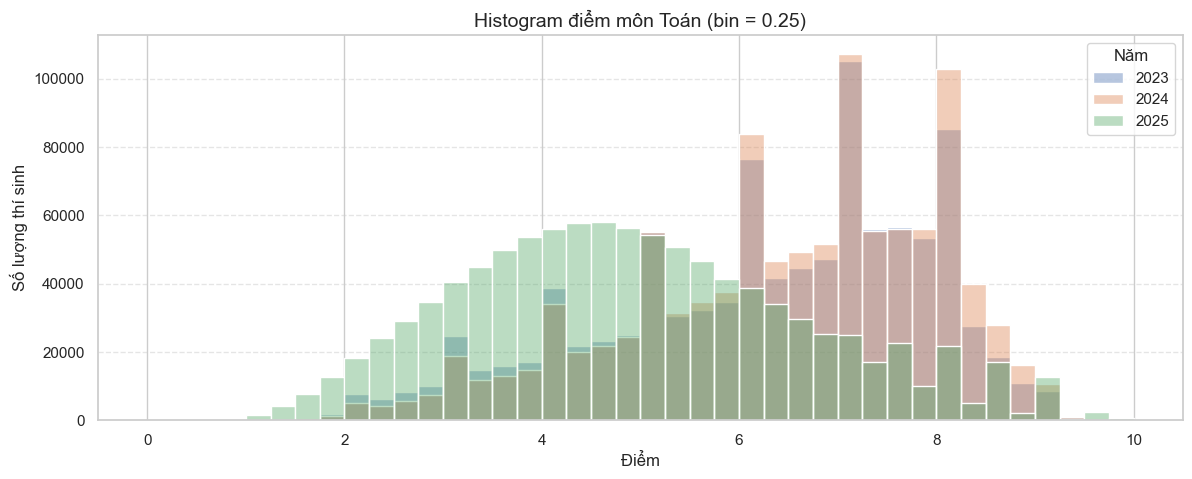

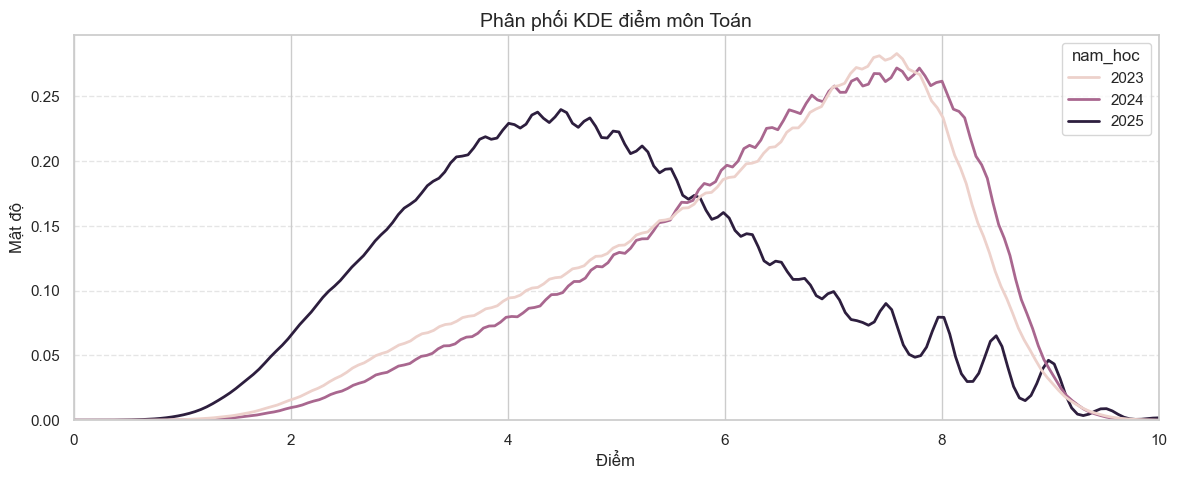

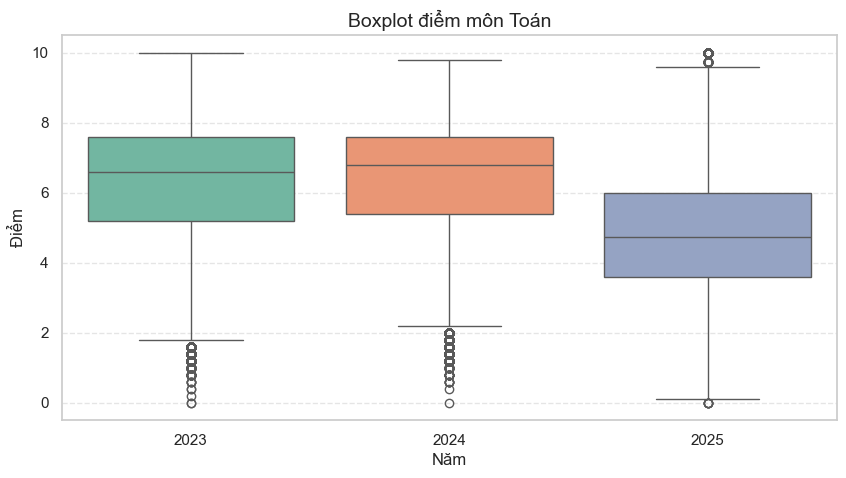


📊 Bảng thống kê mô tả:


,mean,median,std,%>=5,%>=8
2023,6.250557,6.60,1.633335,78.36,15.16
2024,6.447309,6.80,1.556899,82.51,18.97
2025,4.855139,4.75,1.708308,45.40,6.12


------------------------------------------------------------
📌 Đang xử lý môn: Ngữ Văn (ngu_van)


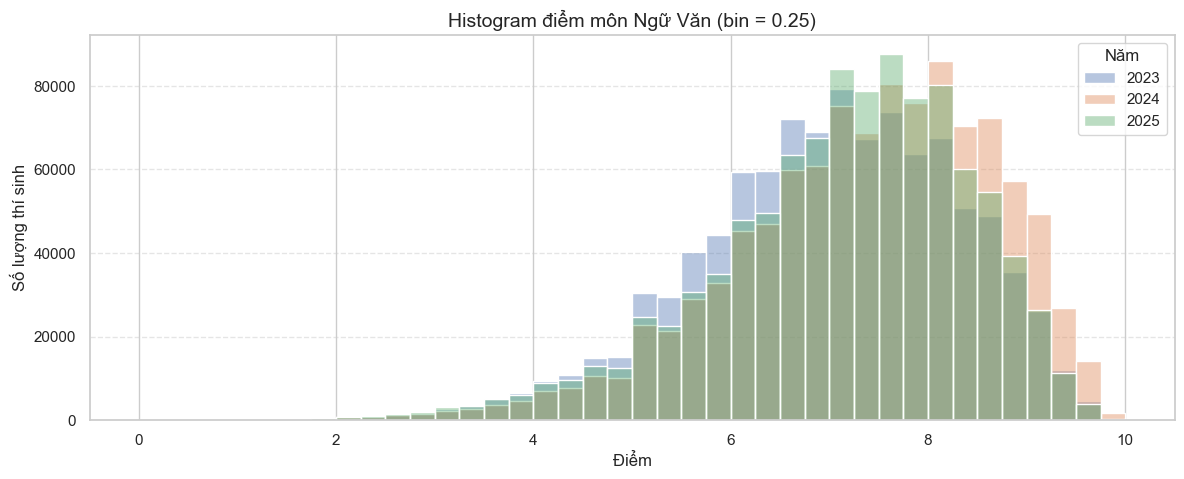

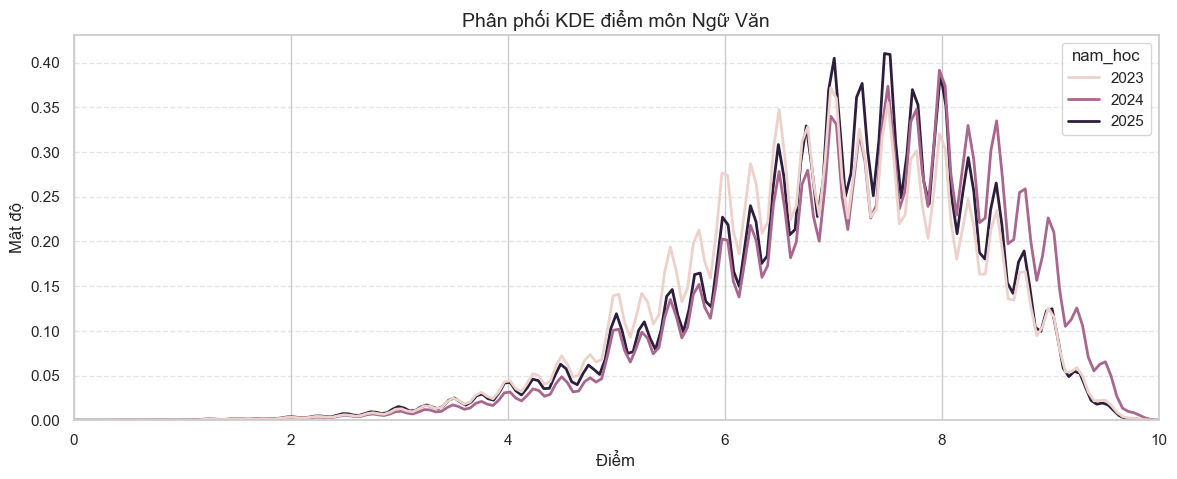

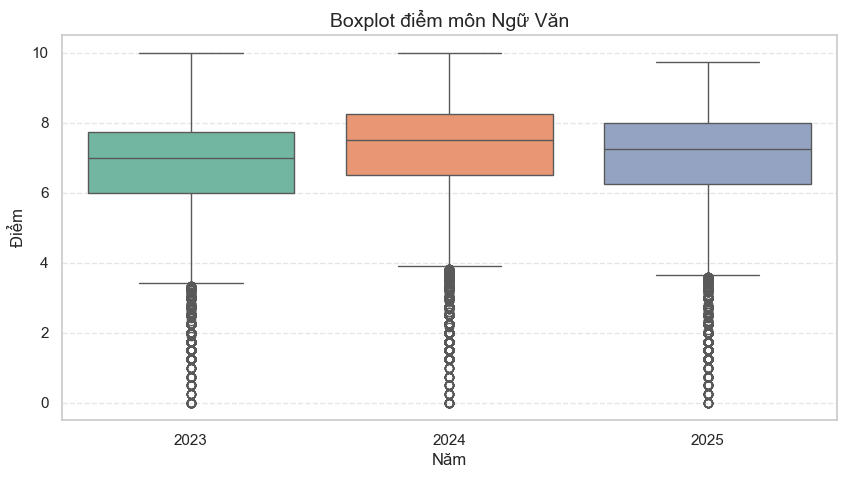


📊 Bảng thống kê mô tả:


,mean,median,std,%>=5,%>=8
2023,6.858194,7.00,1.326470,92.69,24.42
2024,7.231146,7.50,1.330057,94.93,35.99
2025,6.996160,7.25,1.308114,93.23,27.24


------------------------------------------------------------
📌 Đang xử lý môn: Ngoại Ngữ (ngoai_ngu)


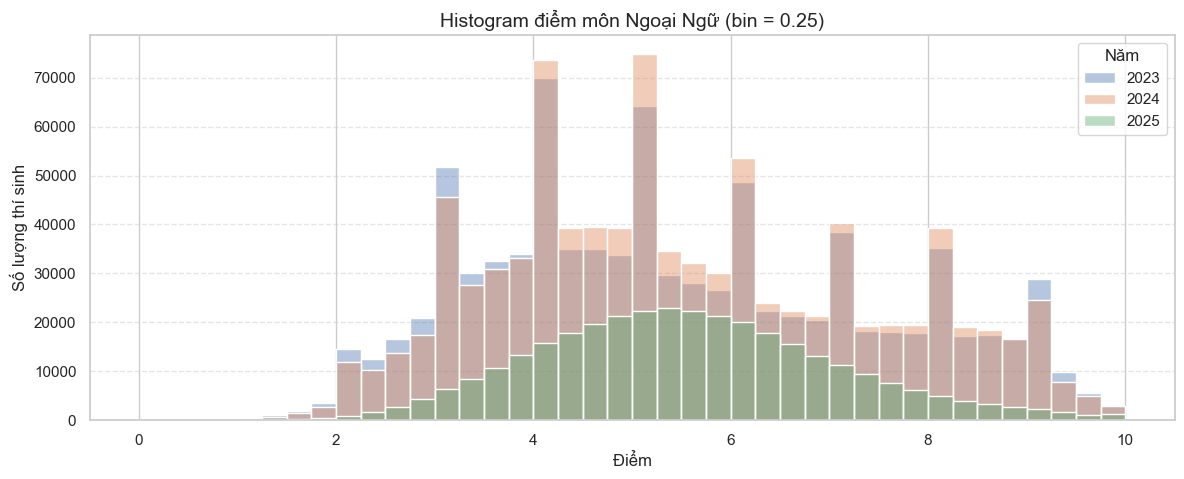

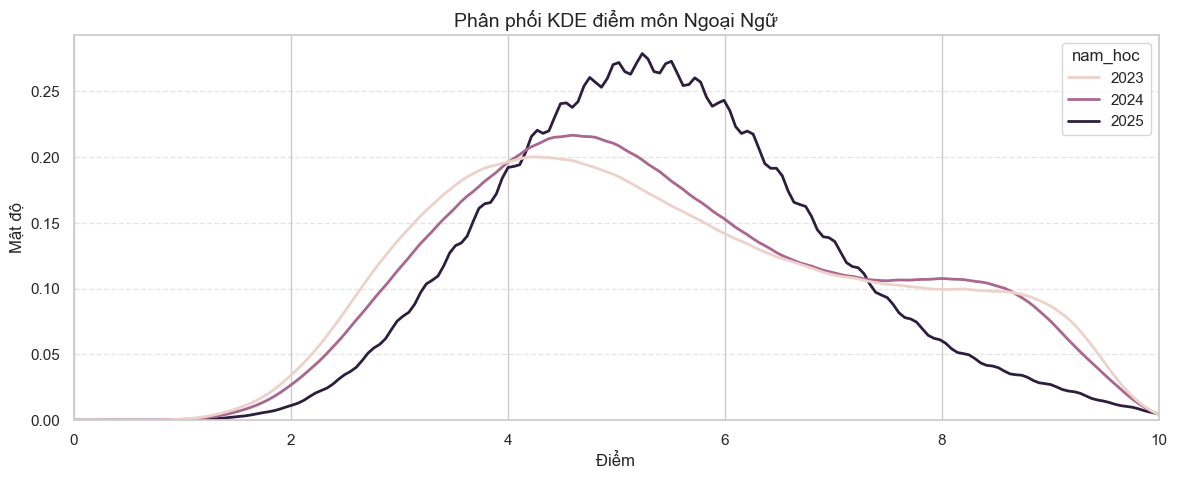

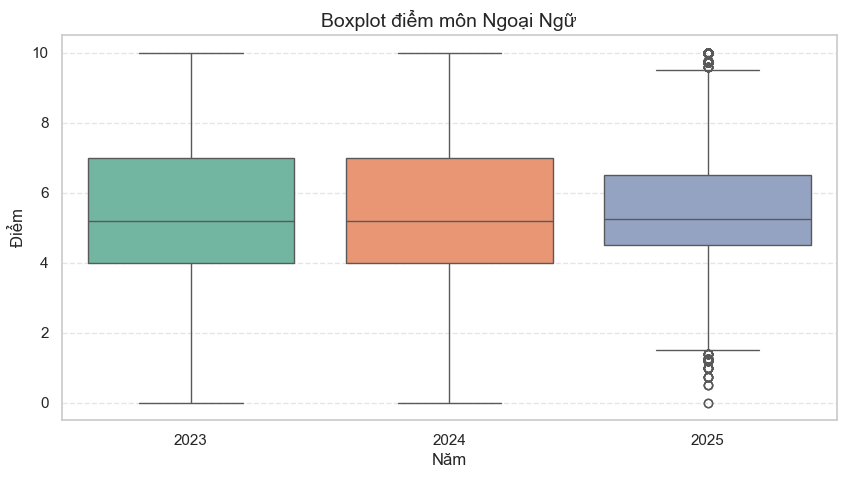


📊 Bảng thống kê mô tả:


,mean,median,std,%>=5,%>=8
2023,5.462410,5.20,1.966352,55.31,15.18
2024,5.521938,5.20,1.880656,57.50,14.62
2025,5.440060,5.25,1.493105,63.02,6.39


------------------------------------------------------------


In [4]:
# EDA theo môn học (Histogram + KDE + Boxplot)
def visualize_subject_eda(subject_code, subject_name):
    """
    Tạo đầy đủ 3 biểu đồ:
    - Histogram theo năm (bin = 0.25)
    - KDE chồng 3 năm
    - Boxplot so sánh phân phối theo năm  
    Kèm bảng thống kê mean/median/std/%>=5/%>=8.
    """

    print(f"📌 Đang xử lý môn: {subject_name} ({subject_code})")

    # 1. Lấy dữ liệu tần suất từ Analysis
    df_agg = analysis.get_arregate_by_exam_subsections(subject_code)

    if df_agg.empty:
        print(f"⚠ Không có dữ liệu cho môn {subject_name}")
        return

    # 2. Tái tạo dữ liệu thô từ tần suất
    raw = []
    for year in sorted(df_agg["nam_hoc"].unique()):
        df_y = df_agg[df_agg["nam_hoc"] == year]
        scores = np.repeat(df_y["diem"].values, df_y["so_hoc_sinh"].values.astype(int))
        raw.append(pd.DataFrame({"nam_hoc": year, "diem": scores}))

    full_df = pd.concat(raw, ignore_index=True)

    # =============================================
    # 1. HISTOGRAM (bin = 0.25)
    # =============================================
    plt.figure(figsize=(14, 5))
    bin_range = np.arange(0, 10.25, 0.25)

    for year in sorted(full_df["nam_hoc"].unique()):
        sns.histplot(
            data=full_df[full_df["nam_hoc"] == year], 
            x="diem", 
            bins=bin_range, 
            label=str(year), 
            kde=False, 
            alpha=0.4
        )

    plt.title(f"Histogram điểm môn {subject_name} (bin = 0.25)", fontsize=14)
    plt.xlabel("Điểm")
    plt.ylabel("Số lượng thí sinh")
    plt.legend(title="Năm")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.show()

    # =============================================
    # 2. KDE CHỒNG 3 NĂM
    # =============================================
    plt.figure(figsize=(14, 5))

    sns.kdeplot(
        data=full_df,
        x="diem",
        hue="nam_hoc",
        common_norm=False,
        fill=False,
        linewidth=2
    )

    plt.title(f"Phân phối KDE điểm môn {subject_name}", fontsize=14)
    plt.xlabel("Điểm")
    plt.ylabel("Mật độ")
    plt.xlim(0, 10)
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.show()

    # =============================================
    # 3. BOXPLOT (Không cảnh báo palette)
    # =============================================
    plt.figure(figsize=(10, 5))

    sns.boxplot(
        data=full_df,
        x="nam_hoc",
        y="diem",
        hue="nam_hoc",        # thêm hue → không bị warning
        dodge=False,          # tránh vẽ 2 box trùng
        palette="Set2"
    )

    plt.title(f"Boxplot điểm môn {subject_name}", fontsize=14)
    plt.xlabel("Năm")
    plt.ylabel("Điểm")
    plt.grid(axis="y", linestyle="--", alpha=0.5)

    # Bỏ duplicate legend
    plt.legend().remove()
    plt.show()

    # =============================================
    # 4. BẢNG THỐNG KÊ MÔ TẢ
    # =============================================
    stats_raw = analysis.get_statistics_by_subject(subject_code)
    stats_df = pd.DataFrame(stats_raw).T

    # Tính thêm tỷ lệ >=5 và >=8
    for year in stats_df.index:
        df_y = df_agg[df_agg["nam_hoc"] == year]
        total = df_y["so_hoc_sinh"].sum()
        ge5 = df_y[df_y["diem"] >= 5]["so_hoc_sinh"].sum()
        ge8 = df_y[df_y["diem"] >= 8]["so_hoc_sinh"].sum()
        stats_df.loc[year, "%>=5"] = round(ge5 / total * 100, 2)
        stats_df.loc[year, "%>=8"] = round(ge8 / total * 100, 2)

    print("\n📊 Bảng thống kê mô tả:")
    display(stats_df[["mean", "median", "std", "%>=5", "%>=8"]])
    print("-" * 60)


# Chạy thử:
visualize_subject_eda("toan", "Toán")
visualize_subject_eda("ngu_van", "Ngữ Văn")
visualize_subject_eda("ngoai_ngu", "Ngoại Ngữ")


--- Đang tổng hợp dữ liệu các khối thi... ---


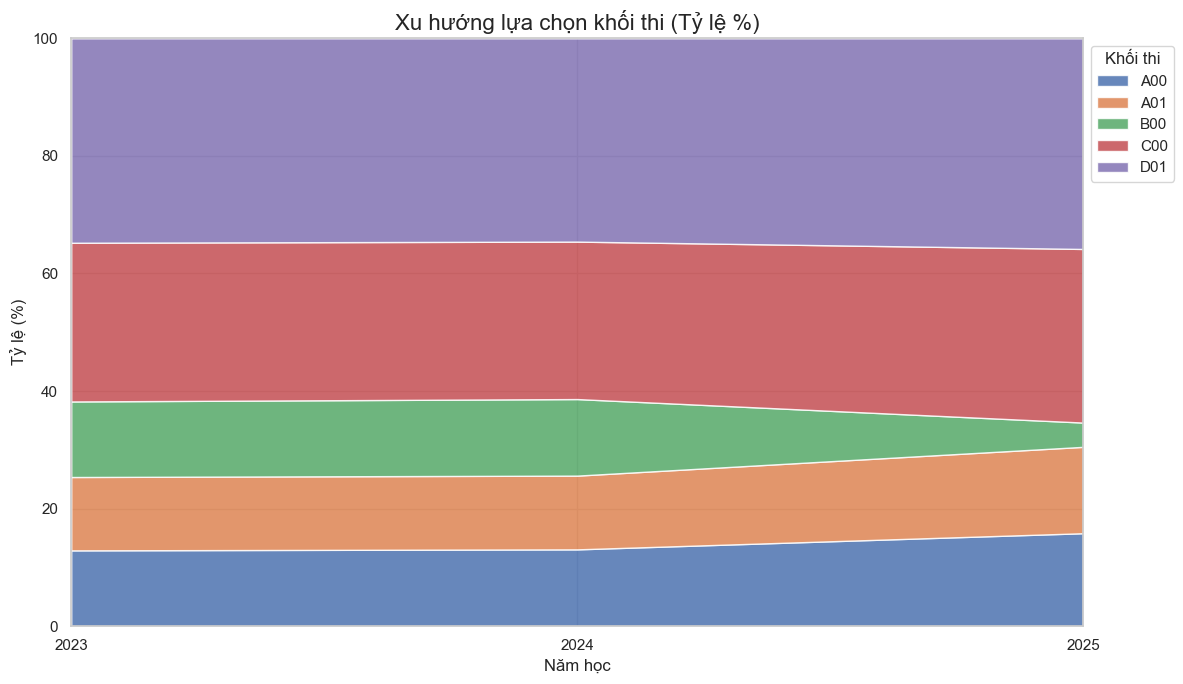


📊 Bảng số lượng thí sinh chi tiết:


,A00,A01,B00,C00,D01
nam_hoc,,,,,
2023,325902,315146,324554,681723,878007
2024,343800,329761,342291,704008,908866
2025,146886,136367,38283,274086,332510


In [ ]:
# Cell 3: Phân tích xu hướng chọn khối thi (FIXED X-AXIS)

def visualize_block_trends(blocks=['A00', 'B00', 'C00', 'D01']):
    """
    Vẽ biểu đồ Stacked Area thể hiện tỷ lệ thí sinh chọn các khối.
   
    """
    
    print("--- Đang tổng hợp dữ liệu các khối thi... ---")

    df = processor.get_processed_data()

    # Map môn trong khối (chuẩn Bộ GD)
    block_map = {
        "A00": ["toan", "vat_li", "hoa_hoc"],
        "A01": ["toan", "vat_li", "ngoai_ngu"],
        "B00": ["toan", "hoa_hoc", "sinh_hoc"],
        "C00": ["ngu_van", "lich_su", "dia_li"],
        "D01": ["toan", "ngu_van", "ngoai_ngu"]
    }

    # Alias xử lý tên cột không đồng nhất
    alias = {
        "vat_li": ["vat_li", "ly"],
        "hoa_hoc": ["hoa_hoc", "hoa"],
        "sinh_hoc": ["sinh_hoc", "sinh"],
        "lich_su": ["lich_su", "su"],
        "dia_li": ["dia_li", "dia"],
        "ngu_van": ["ngu_van", "van"],
        "ngoai_ngu": ["ngoai_ngu", "anh"]
    }

    def find_real_col(mon):
        if mon not in alias:
            return mon
        for c in alias[mon]:
            if c in df.columns:
                return c
        return None

    # Tính số lượng thí sinh
    result = {}
    for block in blocks:
        if block not in block_map: continue

        subjects = []
        for subj in block_map[block]:
            real = find_real_col(subj)
            if real is not None:
                subjects.append(real)

        if len(subjects) < 3:
            print(f"⚠ Khối {block} thiếu môn -> bỏ qua")
            continue

        # Lấy thí sinh thi đủ 3 môn của khối
        df_block = df[["nam_hoc"] + subjects].dropna()
        count = df_block.groupby("nam_hoc").size()
        result[block] = count

    # Tạo DataFrame & Tính %
    df_trends = pd.DataFrame(result).fillna(0).astype(int)
    
    if df_trends.empty:
        print("⚠ Không có dữ liệu!")
        return

    # Sắp xếp index (năm) để đảm bảo đúng thứ tự
    df_trends = df_trends.sort_index()
    
    df_percent = df_trends.div(df_trends.sum(axis=1), axis=0) * 100

    # --- VẼ BIỂU ĐỒ ---
    plt.figure(figsize=(12, 7))
    
    # Vẽ Stackplot
    plt.stackplot(df_percent.index, df_percent.T.values, labels=df_percent.columns, alpha=0.85)
    
    plt.title("Xu hướng lựa chọn khối thi (Tỷ lệ %)", fontsize=16)
    plt.xlabel("Năm học", fontsize=12)
    plt.ylabel("Tỷ lệ (%)", fontsize=12)
    plt.legend(loc="upper left", title="Khối thi", bbox_to_anchor=(1, 1))
    
    # --- FIX LỖI TRỤC HOÀNH Ở ĐÂY ---
    # Chỉ lấy các năm có trong index và ép về kiểu int để hiển thị
    years = df_percent.index.astype(int).tolist()
    plt.xticks(years, [str(y) for y in years]) 
    
    # Giới hạn trục x cho gọn
    plt.xlim(min(years), max(years))
    plt.margins(0, 0) # Bỏ khoảng trắng thừa 2 bên
    
    plt.tight_layout()
    plt.show()

    print("\n📊 Bảng số lượng thí sinh chi tiết:")
    display(df_trends)

# --- CHẠY ---
visualize_block_trends(['A00', 'A01', 'B00', 'C00', 'D01'])


# Theo Tổ Hợp

In [ ]:
# Xử lý data theo tổ hợp khối

# Theo Năm 

In [ ]:
# Xử lý data qua từng năm